# C1 - Introduction to Human and Computer Vision
## Week 4

In [1]:
import os
import re
import matplotlib.pyplot as plt
import cv2
import pickle
import numpy as np

# Get project's root directory
BASE_PATH = os.path.join(re.search(r'.+(Team5)', os.getcwd())[0], 'week4')
os.chdir(BASE_PATH)
BASE_PATH

DATA_DIRECTORY = '../data'

In [2]:
# Read pickle file to see detailed info of the images augmentation
with open(f'{DATA_DIRECTORY}/qsd1_w4/augmentations.pkl', 'rb') as f:
    augmentations_info = pickle.load(f)

# Read pickle file with correspondences
with open(f'{DATA_DIRECTORY}/qsd1_w4/gt_corresps.pkl', 'rb') as f:
    ground_truth = pickle.load(f)

### a) Remove background, detect noise (and filter it)

In [3]:
from src.background_removal import background_removal
from src.noise_removal import denoise_image
from tqdm import tqdm

# Image names
QSD1_w4_names = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd1_w4/') if f.endswith('.jpg')]
QSD1_w4_names.sort()

# Initialize datasets
BBDD = []
QSD1_w4 = []
QSD1_w4_filtered = []
QSD1_w4_nonAugmented = []

# Load datasets (+ filter)
for image_name in tqdm(QSD1_w4_names):
    # Read QSD1_w4
    image_qsd1 = cv2.imread(f'{DATA_DIRECTORY}/qsd1_w4/{image_name}')
    QSD1_w4.append(image_qsd1)

    # Read non-augmented image
    image_nonAugmented = cv2.imread(f'{DATA_DIRECTORY}/qsd1_w4/non_augmented/{image_name}')
    image_nonAug_bckg_remov = background_removal(image_nonAugmented)  # Remove background in non-augmented image
   
    QSD1_w4_nonAugmented.append(image_nonAug_bckg_remov)

    # Filter image from QSD1_w4
    filtered_image = background_removal(denoise_image(image_qsd1))  # Detect noise (and clean it) + Remove background
    QSD1_w4_filtered.append(filtered_image)


# Read BBDD
BBDD_names = [f for f in os.listdir(f'{DATA_DIRECTORY}/BBDD/') if f.endswith('.jpg')]
BBDD_names.sort()

for image_name in tqdm(BBDD_names):
    image_bbdd = cv2.imread(f'{DATA_DIRECTORY}/BBDD/{image_name}')
    BBDD.append(image_bbdd)

100%|██████████| 287/287 [00:03<00:00, 89.00it/s] 


IndexError: list index out of range

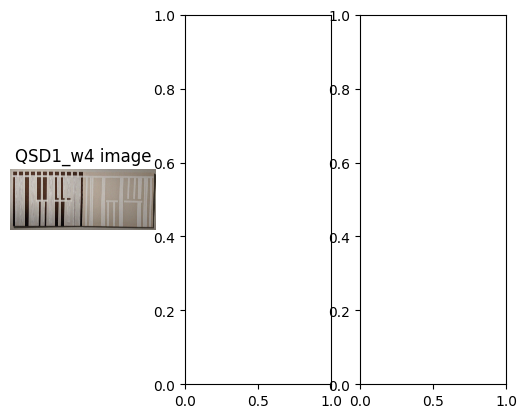

In [44]:
# Plot some examples
img_number = 17


fig, axes = plt.subplots(1, 3)  # 1 fila, 3 columnas

# QSD1_w4 image
image = QSD1_w4[img_number]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
axes[0].imshow(image)
axes[0].set_title('QSD1_w4 image')
axes[0].axis('Off')

# Filtered image (background removal + denoise)
image = QSD1_w4_filtered[img_number][0]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
axes[1].imshow(image)
axes[1].set_title('Filtered image')
axes[1].axis('Off')

# Non-augmented image
image = QSD1_w4_nonAugmented[img_number][0]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
axes[2].imshow(image)
axes[2].set_title('Non-augmented image')
axes[2].axis('Off')

plt.show()
plt.close()

### b) Detect keypoints and compute descriptors

In [8]:
'''
flags = {
  DEFAULT = 0,
  DRAW_OVER_OUTIMG = 1,
  NOT_DRAW_SINGLE_POINTS = 2,
  DRAW_RICH_KEYPOINTS = 4
}
'''
def draw_keypoints(image, kp, flags=0):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img2 = cv2.drawKeypoints(gray_image, kp, None,(255,0,0),flags=flags)
    plt.imshow(img2) 

#### SIFT

In [9]:
def sift_descriptor(image, params={}):
    '''
    Compute SIFT descriptors for a given image
    :param image: image to compute the descriptors
    :param params: parameters for the SIFT algorithm
    :return: keypoints and descriptors

    default params = {
        'nfeatures': 0,
        'nOctaveLayers': 3,
        'contrastThreshold': 0.04,
        'edgeThreshold': 10,
        'sigma': 1.6
    }
    '''
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create(**params)
    kp, des = sift.detectAndCompute(img_gray, None)

    return (kp, des)

In [51]:

params = {
    'nfeatures': 1500,
    'nOctaveLayers': 3,
}

sift_query = []
for picture in tqdm(QSD1_w4_filtered):
    res = []
    for painting in picture:
        kp, des = sift_descriptor(painting, params=params)
        res.append({'kp': kp, 'des': des})
    sift_query.append(res)


sift_bd = []
for painting in tqdm(BBDD):
    kp, des = sift_descriptor(painting, params=params)
    sift_bd.append({'kp': kp, 'des': des})

100%|██████████| 287/287 [02:46<00:00,  1.73it/s]


In [66]:
idx1 = 16 # Query image
idx2 = 11 # BBDD image

des1 = sift_query[idx1][0]['des']
des2 = sift_bd[idx2]['des']

Distance: 268.2638375418527


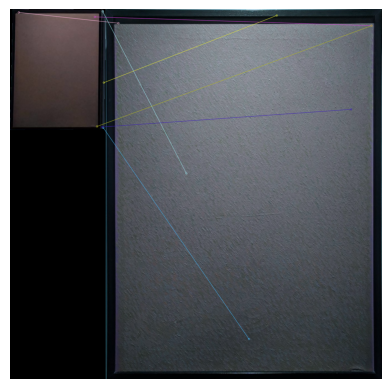

(<matplotlib.image.AxesImage at 0x7e1c09f47530>,
 (np.float64(-0.5), np.float64(1345.5), np.float64(1339.5), np.float64(-0.5)),
 None)

In [67]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv2.drawMatches(
    QSD1_w4_filtered[idx1][0], sift_query[idx1][0]['kp'],
    BBDD[idx2], sift_bd[idx2]['kp'],
    matches[:20], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
print('Distance:', np.mean([m.distance for m in matches]))
plt.imshow(img3), plt.axis('off'), plt.show()

In [87]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

res = []
dist_res = []
for i in tqdm(range(30)):
    picture_res = []
    picture_distances = []
    for j in range(0, len(sift_query[i])):
        distances = []
        for k in range(0, len(sift_bd)):
            if sift_bd[k]['des'] is not None:
                matches = bf.match(sift_query[i][j]['des'], sift_bd[k]['des'])
                matches = sorted(matches, key = lambda x:x.distance)
                # Take top 20 matches
                distance = np.mean([match.distance for match in matches[:20]])
                distances.append(distance)
            else:
                distances.append(10000)

        # Take top 10 matches
        most_similar = np.argsort(distances)[:10]
        most_similar_distances = [distances[idx] for idx in most_similar]
        if most_similar_distances[0] == 10000:
            most_similar = [-1]
            most_similar_distances = [10000]
        if (
            most_similar_distances[1] - most_similar_distances[0] < 
            2*np.mean(np.array(most_similar_distances[2:10]) - np.array(most_similar_distances[1:9]))
        ):
            most_similar = [-1]
        picture_res.append(most_similar)
        picture_distances.append(most_similar_distances)
    
    res.append(picture_res)
    dist_res.append(picture_distances)


100%|██████████| 30/30 [02:34<00:00,  5.16s/it]


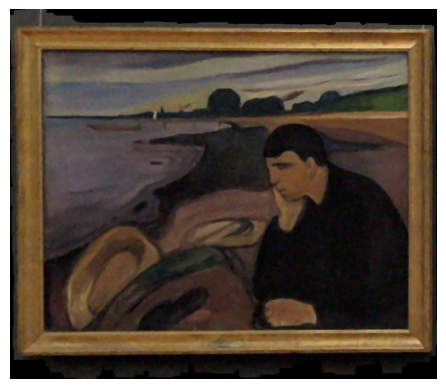

In [88]:
image = QSD1_w4_filtered[24][0]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

In [89]:
import importlib
import src.metrics  # re-import the module to make sure it's recognized
importlib.reload(src.metrics)

from src.metrics import mapk

# Now you can call the updated mapk function
mapk(ground_truth, res, k=1)


-1 [-1]
48 [ 48 279 233  70  36  68 196 285  76 270]
251 [251 188 279  36 236 258 116  19 158 117]
32 [ 32 206  36 190 258 117   4 275 116 285]
161 [161   4  45  26 259 190 196 116 186 275]
81 [ 81   4 258 190 186  45  26 255 116 259]
62 [ 62 169 190  45 258 275 196 131 159  28]
38 [ 38  45 150  69  95  68  67 227 178 258]
-1 [ 26   4 234   9 256  70  69 116 275 282]
128 [-1]
155 [155 258 131 285 144 280  45  68 180  89]
258 [258 190  45 285 169 264 280  43 216 159]
136 [136 258 190  28 282  32 256  76 116 169]
76 [ 76  28 282  26 190 216 258   4  45 110]
-1 [-1]
-1 [-1]
53 [-1]
-1 [261 264  41  40 233 120  14 258   4  19]
12 [ 12 190 258 279 261 264  86 201 196  36]
11 [188 285 279 260 277 261 116 131 133 258]
280 [280 252 258 181 224 108 158 186 133 259]
182 [182 275  36 186 190 259 264  68 279  94]
252 [252 188 206 264  19 186   4 116 275  68]
-1 [121 271 153 216 118  37   9  15 154 126]
272 [272 279 224 270  41 199   5 190  77 264]
117 [117  36 285 190 188 258  45 280 264 260]
-1 [

np.float64(0.7837837837837838)

#### HOG

In [ ]:
from skimage.feature import hog
from skimage import exposure
from scipy.spatial.distance import euclidean

params={
    'shape': (256,256),  # Shape we want to resize the image to
    'pixels_per_cell': (8,8),
    'cells_per_block': (2,2),
}

def hog_descriptor(image, shape: tuple, pixels_per_cell: tuple, cells_per_block: tuple):
    
    # Image to grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize image (we need same dimensions in all the image descriptros to compare)
    image = cv2.resize(image, shape)

    # Compute HOG
    hog_descriptor, hog_image = hog(image, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)
    
    # Rescale intensity, otherwise we may see everyhing black
    hog_image = exposure.rescale_intensity(hog_image, in_range=(0, np.max(hog_image)/10))

    return hog_descriptor, hog_image


In [5]:
hog_query = []
original_query = [ ]  # Imatges del QSD1_W4 una vegada hem aplicat el background removal i en cas que hi hagi dos quadres els separem en dues imatges diferents
for picture in tqdm(QSD1_w4_filtered):
    for painting in picture: 
        original_query.append(painting)      
        des, image = hog_descriptor(painting, **params)
        hog_query.append({'descriptor': des, 'image': image})


hog_bd = []
for painting in tqdm(BBDD):    
    des, image = hog_descriptor(painting, **params)
    hog_bd.append({'descriptor': des, 'image': image})


100%|██████████| 287/287 [00:14<00:00, 19.86it/s]


In [ ]:
k = 5

res = []
distances_res = []

for query in tqdm(hog_query):
    query_descriptor = query['descriptor']
    distances = []
    
    for i, bd_entry in enumerate(hog_bd):
        bd_descriptor = bd_entry['descriptor']
        distance = euclidean(query_descriptor, bd_descriptor)
        distances.append((distance, i))
    
    distances.sort(key=lambda x: x[0])  # Ordenar por la distancia
    nearest_neighbors = [idx for _, idx in distances[:k]]
    nearest_distances = [round(dist, 2) for dist, _ in distances[:k]]
    
    res.append(nearest_neighbors)
    
    distances_res.append(nearest_distances)

print(res)
print(distances_res)

100%|██████████| 37/37 [00:00<00:00, 55.42it/s]

[[40, 282, 11, 32, 286], [48, 254, 238, 11, 21], [251, 282, 11, 32, 127], [32, 11, 282, 193, 40], [161, 11, 40, 32, 282], [81, 40, 11, 32, 161], [54, 238, 202, 239, 282], [38, 182, 229, 67, 141], [282, 40, 32, 255, 123], [128, 54, 238, 11, 282], [155, 11, 282, 54, 238], [258, 215, 57, 160, 259], [136, 137, 54, 104, 244], [21, 92, 54, 238, 202], [78, 21, 74, 12, 107], [32, 11, 282, 193, 54], [53, 238, 54, 254, 92], [93, 197, 198, 46, 200], [12, 21, 74, 238, 92], [282, 11, 245, 36, 32], [232, 282, 32, 160, 233], [233, 282, 51, 215, 178], [215, 57, 259, 51, 261], [93, 198, 78, 274, 16], [272, 282, 32, 42, 11], [117, 88, 32, 282, 11], [54, 238, 11, 92, 180], [242, 176, 221, 54, 202], [260, 163, 40, 113, 160], [94, 215, 232, 239, 57], [132, 104, 215, 57, 88], [57, 9, 174, 104, 218], [78, 74, 221, 21, 12], [127, 282, 32, 11, 140], [47, 229, 52, 215, 57], [13, 115, 225, 238, 100], [11, 282, 32, 193, 40]]
[[19.37, 19.92, 20.29, 20.32, 20.51], [21.66, 22.85, 22.87, 23.09, 23.12], [16.22, 21.29,

In [ ]:
import importlib
import src.metrics 
importlib.reload(src.metrics)

from src.metrics import mapk

mapk(ground_truth, res, k=1)

-1 40


TypeError: object of type 'int' has no len()

#### DAISY

In [ ]:
from skimage.feature import daisy

def daisy_descriptor(image, step=250, radius=50, rings=3, histograms=6, orientations=8):
    # Convertimos la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculamos los descriptores DAISY sin visualización
    descriptors, dsc_image = daisy(
        gray_image,
        step=step,
        radius=radius,
        rings=rings,
        histograms=histograms,
        orientations=orientations,
        visualize=True
    )
    
    return descriptors, dsc_image


In [30]:
def daisy_descriptor(image, step=158, radius=50, rings=3, histograms=6, orientations=8):
    # Convertimos la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Usamos un detector de keypoints (aquí FAST, pero puedes usar otros)
    fast = cv2.FastFeatureDetector_create()
    keypoints = fast.detect(gray_image, None)
    
    # Calculamos los descriptores DAISY en los puntos clave detectados
    descriptors = daisy(
        gray_image,
        step=step,
        radius=radius,
        rings=rings,
        histograms=histograms,
        orientations=orientations,
        visualize=False
    )
    
    # Alineamos los descriptores con los keypoints (si es necesario)
    keypoints_daisy = []
    keypoint_descriptors = []
    
    for kp in keypoints:
        # Para cada keypoint, calculamos su posición (en coordenadas de píxeles)
        y, x = kp.pt
        x, y = int(x), int(y)
        
        # Aquí usamos una verificación simple, que si el keypoint está dentro de la imagen
        if x < descriptors.shape[1] and y < descriptors.shape[0]:
            keypoints_daisy.append(kp)
            keypoint_descriptors.append(descriptors[y, x, :])  # Tomamos el descriptor en esa ubicación
    
    # Convertimos las listas a arrays de numpy para facilitar el uso
    keypoints_daisy = np.array(keypoints_daisy)
    keypoint_descriptors = np.array(keypoint_descriptors)
    
    return keypoints_daisy, keypoint_descriptors

In [31]:
daisy_query = []
for picture in tqdm(QSD1_w4_filtered[:4]):
    for painting in picture:
        kp, des = daisy_descriptor(painting)
        daisy_query.append({'kp': kp, 'des': des})


daisy_bd = []
for picture in tqdm(QSD1_w4_nonAugmented[:4]):
    for painting in picture:
        kp, des = daisy_descriptor(painting)
        daisy_bd.append({'kp': kp, 'des': des})

 25%|██▌       | 1/4 [00:32<01:36, 32.33s/it]


ValueError: negative dimensions are not allowed

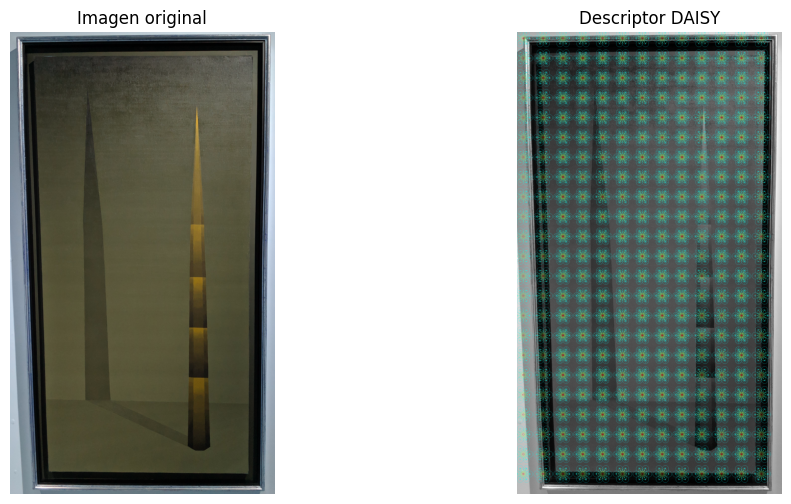

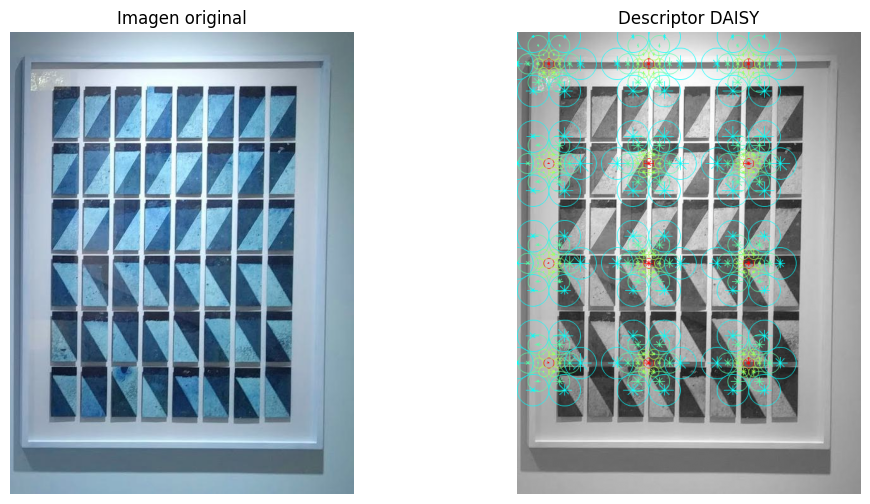

In [13]:
# Mostrar la imagen original y la visualización del descriptor DAISY
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dsc_image, cmap='gray')
plt.title('Descriptor DAISY')
plt.axis('off')

plt.show()

# 2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image1, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dsc_image1, cmap='gray')
plt.title('Descriptor DAISY')
plt.axis('off')

plt.show()

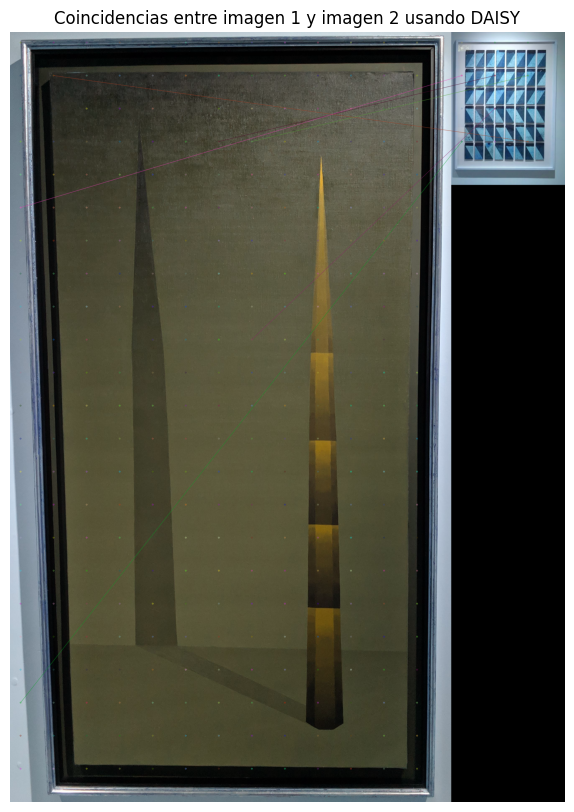

In [20]:
# Convertir descriptores a tipo float32 para el matcher de OpenCV
descriptors = des_daisy.astype(np.float32).reshape(-1, 152)
descriptors1 = des_daisy1.astype(np.float32).reshape(-1, 152)

# Crear el matcher Brute-Force con la métrica de distancia Euclidiana
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Encontrar las mejores coincidencias
matches = bf.match(descriptors, descriptors1)

# Ordenar las coincidencias por distancia (las más cercanas son las mejores)
matches = sorted(matches, key=lambda x: x.distance)

# Para dibujar los keypoints necesitamos crear un arreglo de KeyPoint
# Generar keypoints para la primera y segunda imagen a partir de la malla DAISY
keypoints = []
keypoints1 = []

step = 158  # El valor del 'step' usado en DAISY
radius = 50  # El radio del descriptor

# Generar keypoints para la imagen original
for i in range(des_daisy.shape[0]):
    for j in range(des_daisy.shape[1]):
        keypoints.append(cv2.KeyPoint(j * step + radius, i * step + radius, 1))

# Generar keypoints para la segunda imagen
for i in range(des_daisy1.shape[0]):
    for j in range(des_daisy1.shape[1]):
        keypoints1.append(cv2.KeyPoint(j * step + radius, i * step + radius, 1))

# Dibujar los matches entre las imágenes
img_matches = cv2.drawMatches(
    image, keypoints,  # Imagen original y sus keypoints
    image1, keypoints1,  # Imagen de referencia y sus keypoints
    matches[:30], None
)

# Mostrar el resultado con matplotlib
plt.figure(figsize=(15, 10))
plt.imshow(img_matches)
plt.title('Coincidencias entre imagen 1 y imagen 2 usando DAISY')
plt.axis('off')  # Desactivar los ejes para que sea más limpio
plt.show()



In [8]:
surf_query = []
for picture in tqdm(QSD1_w4_filtered):
    for painting in picture:
        kp, des = surf_descriptor(painting)
        surf_query.append({'kp': kp, 'des': des})


surf_bd = []
for picture in tqdm(QSD1_w4_nonAugmented):
    for painting in picture:
        kp, des = surf_descriptor(painting)
        surf_bd.append({'kp': kp, 'des': des})

  0%|          | 0/30 [00:00<?, ?it/s]


AttributeError: module 'cv2' has no attribute 'SURF_create'

#### ORB

In [ ]:
def orb_descriptor(image, params={}):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create(**params)
    kp, des = orb.detectAndCompute(img_gray, None)

    return (kp, des)

# Task 2

### a) Find tentative matches based on similarity of local appearance and verify matches 

### b) Implement a system to discard queries not in the data set (unknowns)

# Task 3

### a) Evaluate system based on keypoint descriptors on QSD1-W4

### b) Compare your best query system from previous week on QSD1-W4

# Task 4

### a) Create pkl file